# Filtracja Non-Local Means

## Definicja

Kolejny "poziom wtajemniczenia" w zagadnienie filtracji obrazów to metoda Non-Local Means (NLM).
Została ona zaproponowana w pracy *A non-local algorithm for image denoising* autorstwa Antoni Buades, Bartomeu Coll, i Jean Michel Morel na konferencji CVPR w 2005 roku.

Filtr NLM dany jest zależnością:

\begin{equation}
\hat{I}(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} w(\mathbf{p},\mathbf{x})I(\mathbf{p})
\end{equation}

gdzie:
- $I$ - obraz wejściowy,
- $\hat{I}$ - obraz wyjściowy (przefiltrowany),
- $\mathbf{x}$ - współrzędne piksela obrazu,
- $V(\mathbf{x})$ - obszar poszukiwań piksela, dla którego przeprowadzana jest filtracja,
- $w$ - waga punktu $\mathbf{p}$ z obszaru poszukiwań.

Wróćmy na chwilę do filtracji bilateralnej. Tam waga danego piksela z kontekstu zależała od dwóch czynników - odległości przestrzennej pomiędzy pikselami oraz różnicy w jasności/kolorze pomiędzy pikselami (tzw. przeciwdziedzina).
Filtr NLM stanowi uogólnienie tej metody - do obliczania wag nie wykorzystuje się już pojedynczych pikseli ($\mathbf{p}$ i $\mathbf{x}$), a lokalne konteksty ($N(\mathbf{p})$ i $N(\mathbf{x})$).

Waga $w$ dana jest następującą zależnością:

\begin{equation}
w(\mathbf{p},\mathbf{x}) = \frac{1}{Z(\mathbf{x})}\exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\end{equation}

gdzie:
- \begin{equation}
Z(\mathbf{x}) = \sum_{\mathbf{p} \in  V(\mathbf{x})} \exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\end{equation},
- $|| \cdot ||$ - jest normą $L_2$ odległości pomiędzy dwoma kontekstami,
- $v$ oznacza mnożenie punktowe kontekstu $N$ przez dwuwymiarową maskę Gaussa o odpowiadających kontekstowi wymiarach,
- $\alpha$ > 0 - parametr sterujący filtracją,
- $\sigma$ - parametr szumu stacjonarnego występującego na obrazie (w przypadku szumu niestacjonarnego, parametr $\sigma$ musi zostać dopasowany lokalnie tj. $\sigma = \sigma(\mathbf{x})$).

## Analiza działania

Zastanówmy sie teraz jak działa filtra NLM. Najprościej to zrozumieć na rysunku.

![Ilustracja NLM](https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/nlm.png)

1. Dla rozważanego piksela $\mathbf{x}$ definiujemy obszar poszukiwań $V(\mathbf{x})$. Uwaga - obszar poszukiwań ($V$) jest jednostką większą niż otocznie/kontekst ($N$).

2. Następnie, dla każdego z pikseli $\mathbf{p} \in  V(\mathbf{x})$ oraz samego $\mathbf{x}$ definiujemy otocznie/kontekst odpowiednio $N(\mathbf{p})$ i $N(\mathbf{x})$.

3. Wracamy do równania definiującego wagę  $w(\mathbf{p},\mathbf{x})$, a konkretnie do wyrażenia $|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||$. Przeanalizujmy co ono oznacza. Mamy dwa otoczenia: $N(\mathbf{p})$ i $N(\mathbf{x})$. Każde z nich mnożymy przez odpowiadającą maskę Gaussa - funkcja $v$. Otrzymujemy dwie macierze, które odejmujemy od siebie punktowo. Następnie obliczamy kwadrat z normy ($L_2$ definiujemy jako $||X||_2 = \sqrt{\sum_k|X_k|^2}$. Otrzymujemy zatem jedną liczbę, która opisuje nam podobieństwo otoczeń pikseli $\mathbf{x}$ i $\mathbf{p}$. Mała wartość oznacza otoczenia zbliżone, duża - różniące się. Ponieważ, z dokładnością do stałych, liczba ta stanowi wykładnik funkcji $e^{-x}$, to ostatecznie waga jest zbliżona do 1 dla otoczeń podobnych, a szybko maleje wraz z malejącym podobieństwem kontekstów.

4. Podsumowując. Jak wynika z powyższej analizy filtr NLM to taki filtr bilateralny, w którym zamiast pojedynczych pikseli porównuje się ich lokalne otoczenia. Wpływa to pozytywnie na jakość filtracji, niestety kosztem złożoności obliczeniowej.

## Implementacja

W ramach zadania należy zaimplementować filtr NLM, ocenić jego działanie w porównaniu do filtra Gaussa i bilateralnego oraz dokonać pomiaru czasu obliczeń (dla trzech wymienionych metod).

Jak już się zrozumie jak działa NLM, jego implementacja jest dość prosta.
Wartość parametru $\alpha$ należy dobrać eksperymentalnie.
Nie należy także "przesadzić" z rozmiarem obszaru poszukiwań (np. 11x11) oraz kontekstu (5x5 lub 3x3).

Wskazówki do implementacji:
- algorytm sprowadza się do dwóch podwójnych pętli for: zewnętrzne po pikselach, wewnętrzne po kolejnych obszarach przeszukań,
- przed realizacją trzeba przemyśleć problem pikseli brzegowych - de facto problemów jest kilka. Po pierwsze nie dla każdego piksela można wyznaczyć pełny obszar przeszukań (tu propozycja, aby filtrację przeprowadzać tylko dla pikseli z pełnym obszarem). Po drugie, ponieważ rozpatrujemy konteksty, to nawet dla piksela o "pełnym" obszarze przeszukań, będą istnieć piksele, dla których nie pełnych kontekstów (sugestia - powiększyć obszar przeszukać, tak aby zawierał konteksty). Ostatni problem jest bardziej techniczny/implementacyjny. Jeśli w kolejnych iteracjach "jawnie" wytniemy fragment o rozmiarach obszaru przeszukiwań, to znowu pojawi się problem brzegowy - tu można albo wyciąć nieco większy obszar, albo cały czas "pracować" na obrazie oryginalnym ("żonglerka indeksami").
- warto sprawdzać indeksy i rozmiary "wycinanych" kontekstów,
- wagi wyliczamy w trzech krokach:
    - obliczenia dla $N(\mathbf{x})$ + inicjalizacja macierzy na wagi,
    - podwójna pętla, w której przeprowadzamy obliczenia dla kolejnych $N(\mathbf{p})$ oraz wyliczamy wagi,
    - normalizacja macierzy wag oraz końcowa filtracja obszaru w wykorzystaniem wag.
- uwaga, obliczenia trochę trwają, nawet dla obrazka 256x256 i względnie niewielkich obszaru przeszukań i kontesktu.

Efekt końcowy:
- porównanie wyników metod: filtr Gaussa, filtr bilateralny oraz filtr NLM (2-3 zdania komentarza),
- porównanie czasu działania powyższych metod (1 zdanie komentarza).


Czas trwania konwolucji  1.3788193
Czas trwania bilateralnej  2.801291
Czas trwania nml  182.14585459999998


(-0.5, 255.5, 255.5, -0.5)

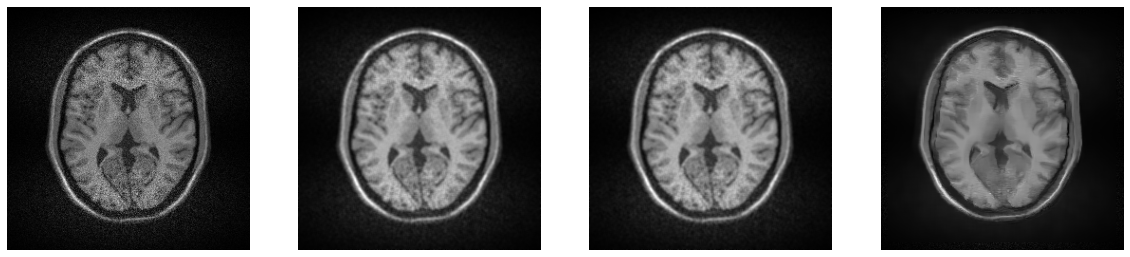

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
from timeit import default_timer as timer
import os

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate
        
        
def fgaussian(size, sigma):
    m = n = size
    h, k = m//2, n//2
    x, y = np.mgrid[-h:h+1, -k:k+1]
    g = np.exp(-(x**2 + y**2)/(2*sigma**2))
    return g /g.sum() 


mat = loadmat('MR_data.mat')
Input = mat['I_noisy2']

start = timer()
def pixel(I, F):
    IF = np.zeros(I.shape)
    for i in range (I.shape[0]):
        for j in range (I.shape[1]):
            IF[i,j] = I[i,j]*F[i,j]
            
    return (np.sum(IF)/np.sum(F)) 
                  
    
window = 3
w = window//2
sigma = 3
f1 = fgaussian(window, sigma)

IC1 = Input.copy()
X,Y = IC1.shape
for i in range (w, X-w):
    for j in range (w, Y-w):
            row_up = i - w
            row_down = i + w +1
            
            col_left = j - w
            col_right = j + w + 1
            
            temp = np.array(Input[row_up : row_down, col_left : col_right])       
            IC1[i,j] = pixel(temp, f1) 
            
end = timer()

time1 = end - start

def pixel_b(I, F, s):
    IF = np.zeros(I.shape)
    for i in range (I.shape[0]):
        for j in range (I.shape[1]):
            d1 = I.shape[0]//2 - i
            d2 = I.shape[1]//2 - j
            dst = (d1**2 + d2**2)**0.5            
            g = np.exp(((-1)*(dst)**2)/(2*(s)**2))
            
            IF[i,j] = I[i,j]*F[i,j]*g
            
    return (np.sum(IF)/np.sum(F)) 
                  

start = timer()
window = 3
w = window//2
sigma = 3
sigma_r = 3
f1 = fgaussian(window, sigma)
IC2 = Input.copy()
X,Y = IC2.shape
for i in range (w, X-w):
    for j in range (w, Y-w):
            row_up = i - w
            row_down = i + w +1
            
            col_left = j - w
            col_right = j + w + 1
            
            temp = np.array(Input[row_up : row_down, col_left : col_right])       
            IC2[i,j] = pixel_b(temp, f1, sigma_r) 
            
end = timer()

time2 = end - start           
start = timer()        
window = 11
context = 5

w = window//2
c = context//2

sigma = 3
f1 = fgaussian(context, sigma)


IC3 = Input.copy()
X,Y = IC3.shape
for i in range (w+c, X-w-c-1):
    for j in range (w+c, Y-w-c -1):
            row_up = i - w
            row_down = i + w +1
            
            row_up_c = i - c
            row_down_c = i + c +1
            
            col_left = j - w
            col_right = j + w + 1
            
            col_left_c = j - c
            col_right_c = j + c + 1
            
            temp = np.array(Input[row_up : row_down, col_left : col_right])               
            temp_c = np.array(Input[row_up_c : row_down_c, col_left_c : col_right_c])    
            
            o_e = np.zeros(temp.shape)
            for k in range (temp.shape[0]):
                for l in range (temp.shape[1]):
                    row_up_x = i - w + k - c
                    row_down_x = i - w + k + c +1

                    col_left_x = j - w + l - c
                    col_right_x = j - w + l + c + 1
                    
                    t = np.array(Input[row_up_x : row_down_x, col_left_x : col_right_x])
                    
                    o = np.dot(t, f1) - np.dot(temp_c, f1)  
                    o_n = (((np.sum(o**2))**0.5))**2        
                    o_e[k,l]= np.exp( ((-1) * o_n) / (14 * ((sigma)**2)))
                    
                    z = np.sum(o_e)
                    ic = np.zeros(temp.shape)
                    
            for k in range (temp.shape[0]):
                for l in range (temp.shape[1]):
                    ic[k, l] = (1/z) * o_e[k,l] * Input[i - 2 + k, j - 2 + l ]
                    
            IC3[i,j] = np.sum(ic)
end = timer()

time3 = end - start
print("Czas trwania konwolucji ",time1)
print("Czas trwania bilateralnej ",time2)
print("Czas trwania nml ",time3)
f, a = plt.subplots(1, 4)
f.set_size_inches(20,10)
a[0].imshow(Input, 'gray')
a[0].axis('off')
a[1].imshow(IC1, 'gray')
a[1].axis('off')
a[2].imshow(IC2, 'gray')
a[2].axis('off')
a[3].imshow(IC3, 'gray')
a[3].axis('off')

                    

# Najlepsze wyniki zwraca nml. Metoda konwolucji i bilateralna tylko po części redukują zakłócenia.

# Wadą jest czas działania, nml działa kilkanaście/kilkadziesiąt razy dłużej.